In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas_profiling
import my_lib as mylib
import scipy.stats as stats
from zipfile import ZipFile

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

%matplotlib inline

import glob, os
SEED = 42
feature_labels = {}

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
df = pd.read_csv(f"data/df_train_sample_00_of_20.csv", dtype=str)
df.head()

,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,SPEC_UNIT_4,SPEC_UNIT_5,PAT_STATE,PAT_ZIP,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,SECONDARY_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_1,OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_2,OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_3,OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_4,OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_5,OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_6,OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_7,OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_8,OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_9,OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_10,OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_11,OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_12,OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_13,OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_14,OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_15,OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_16,OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_17,OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_18,OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_19,OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_20,OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_21,OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_22,OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_23,OTH_DIAG_CODE_24,POA_OTH_DIAG_CODE_24,E_CODE_1,POA_E_CODE_1,E_CODE_2,POA_E_CODE_2,E_CODE_3,POA_E_CODE_3,E_CODE_4,POA_E_CODE_4,E_CODE_5,POA_E_CODE_5,E_CODE_6,POA_E_CODE_6,E_CODE_7,POA_E_CODE_7,E_CODE_8,POA_E_CODE_8,E_CODE_9,POA_E_CODE_9,E_CODE_10,POA_E_CODE_10,PRINC_SURG_PROC_CODE,PRINC_SURG_PROC_DAY,PRINC_ICD9_CODE,OTH_SURG_PROC_CODE_1,OTH_SURG_PROC_DAY_1,OTH_ICD9_CODE_1,OTH_SURG_PROC_CODE_2,OTH_SURG_PROC_DAY_2,OTH_ICD9_CODE_2,OTH_SURG_PROC_CODE_3,OTH_SURG_PROC_DAY_3,OTH_ICD9_CODE_3,OTH_SURG_PROC_CODE_4,OTH_SURG_PROC_DAY_4,OTH_ICD9_CODE_4,OTH_SURG_PROC_CODE_5,OTH_SURG_PROC_DAY_5,OTH_ICD9_CODE_5,OTH_SURG_PROC_CODE_6,OTH_SURG_PROC_DAY_6,OTH_ICD9_CODE_6,OTH_SURG_PROC_CODE_7,OTH_SURG_PROC_DAY_7,OTH_ICD9_CODE_7,OTH_SURG_PROC_CODE_8,OTH_SURG_PROC_DAY_8,OTH_ICD9_CODE_8,OTH_SURG_PROC_CODE_9,OTH_SURG_PROC_DAY_9,OTH_ICD9_CODE_9,OTH_SURG_PROC_CODE_10,OTH_SURG_PROC_DAY_10,OTH_ICD9_CODE_10,OTH_SURG_PROC_CODE_11,OTH_SURG_PROC_DAY_11,OTH_ICD9_CODE_11,OTH_SURG_PROC_CODE_12,OTH_SURG_PROC_DAY_12,OTH_ICD9_CODE_12,OTH_SURG_PROC_CODE_13,OTH_SURG_PROC_DAY_13,OTH_ICD9_CODE_13,OTH_SURG_PROC_CODE_14,OTH_SURG_PROC_DAY_14,OTH_ICD9_CODE_14,OTH_SURG_PROC_CODE_15,OTH_SURG_PROC_DAY_15,OTH_ICD9_CODE_15,OTH_SURG_PROC_CODE_16,OTH_SURG_PROC_DAY_16,OTH_ICD9_CODE_16,OTH_SURG_PROC_CODE_17,OTH_SURG_PROC_DAY_17,OTH_ICD9_CODE_17,OTH_SURG_PROC_CODE_18,OTH_SURG_PROC_DAY_18,OTH_ICD9_CODE_18,OTH_SURG_PROC_CODE_19,OTH_SURG_PROC_DAY_19,OTH_ICD9_CODE_19,OTH_SURG_PROC_CODE_20,OTH_SURG_PROC_DAY_20,OTH_ICD9_CODE_20,OTH_SURG_PROC_CODE_21,OTH_SURG_PROC_DAY_21,OTH_ICD9_CODE_21,OTH_SURG_PROC_CODE_22,OTH_SURG_PROC_DAY_22,OTH_ICD9_CODE_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_ICD9_CODE_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,OTH_ICD9_CODE_24,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,FILLER_SPACE,TARGET
0,320136748870,2013Q3,838400,Memorial Hermann Rehab Hospital Katy,3,4,R,NaN,NaN,NaN,NaN,TX,77095,US,201,06,07,F,4,2,2,1,20,MA,MB,111,1671.00,0.00,1145.00,0.00,526.00,0.00,X,V5789,V5789,NaN,1919,Y,5119,Y,V8543,NaN,78459,Y,27801,Y,7812,Y,5180,Y,34590,Y,4019,Y,7993,Y,2724,Y,72887,Y,36250,Y,78093,Y,36901,Y,V5878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Dealing with missing values in a dataset

#### Do not remove missing data as this can introduced a lot of issues such as:
- data is randomly missing data or potentially loose most of your data
- you are introducing potential biases

#### Alternative solution
- replace missing value with another value
- Strategies: mean, media, highest frequency 

In [62]:
# When building a model it can only process numerical values, therefore an alternative when given a categorical data is to use dummy
# Function to dummy multiple features

def dummyItUp(df,dummy_list):
    for x in dummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

# code below prints a list of all the columns containing a null value
null_list = df.columns[df.isnull().any()].tolist()

# how much of our data is missing?
isnull_count = df.isnull().sum().sort_values(ascending=False).head()

# print count of all unique values in a column
unique_count = df.DISCHARGE.value_counts().sort_values(ascending=False)

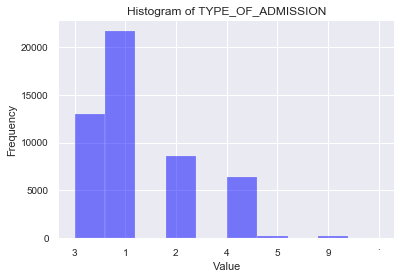

In [56]:
mylib.plot_hist(df.TYPE_OF_ADMISSION)

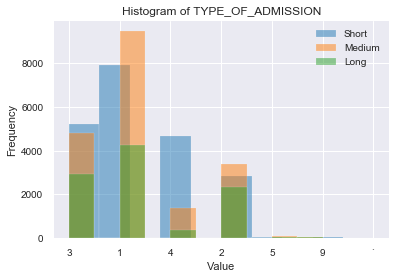

In [57]:
mylib.plot_hist_x_y(df.TYPE_OF_ADMISSION, df.TARGET)

# Feature Engineering
- devide into two classes, increasing and decreasing dimentionality

#### TYPE_OF_ADMISSION

**Distribution**

1    21625
3    12951
2     8564
4     6409
5      233
9      201
`        1
Name: TYPE_OF_ADMISSION, dtype: int64

**Count Plots**

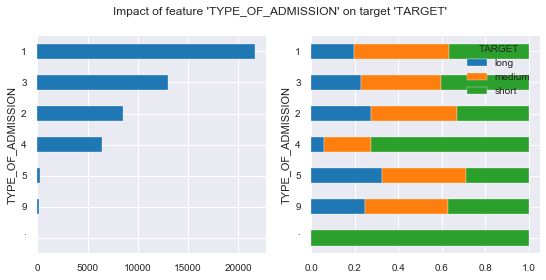

**Chi-Sq Goodness of Fit**

Chi-Square statistic 3.3733e+03 (p=0.0000e+00, dof=12)


In [55]:
f = "TYPE_OF_ADMISSION"
t = "TARGET"
mylib.eda_categorical(df, f, t, max_categories=20, labels=None, header=True, brief=False)

### Convert Tager Categrories into codes or numbers

In [126]:
from sklearn.preprocessing import LabelEncoder

if df.TARGET.dtype != int:
    print("Encoding Taget")
    le = LabelEncoder()
    df["TARGET"] = le.fit_transform(df.TARGET)
else:
    pass

Encoding Taget


In [137]:
nl = []
for i in df.columns:
    if df[i].value_counts().sum() == 0:
        nl.append(i) 
        
# Dropped empty columns
print("Dropping Empty Columns")
df = df.drop(columns=nl)        

Dropping Empty Columns


In [138]:
df.head()

,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,PAT_STATE,PAT_ZIP,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,SECONDARY_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_1,OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_2,OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_3,OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_4,OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_5,OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_6,OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_7,OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_8,OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_9,OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_10,OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_11,OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_12,OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_13,OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_14,OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_15,OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_16,OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_17,OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_18,OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_19,OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_20,OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_21,OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_22,OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_23,OTH_DIAG_CODE_24,POA_OTH_DIAG_CODE_24,E_CODE_1,POA_E_CODE_1,E_CODE_2,POA_E_CODE_2,E_CODE_3,POA_E_CODE_3,E_CODE_4,POA_E_CODE_4,E_CODE_5,POA_E_CODE_5,E_CODE_6,POA_E_CODE_6,E_CODE_7,POA_E_CODE_7,E_CODE_8,PRINC_SURG_PROC_CODE,PRINC_SURG_PROC_DAY,PRINC_ICD9_CODE,OTH_SURG_PROC_CODE_1,OTH_SURG_PROC_DAY_1,OTH_ICD9_CODE_1,OTH_SURG_PROC_CODE_2,OTH_SURG_PROC_DAY_2,OTH_ICD9_CODE_2,OTH_SURG_PROC_CODE_3,OTH_SURG_PROC_DAY_3,OTH_ICD9_CODE_3,OTH_SURG_PROC_CODE_4,OTH_SURG_PROC_DAY_4,OTH_ICD9_CODE_4,OTH_SURG_PROC_CODE_5,OTH_SURG_PROC_DAY_5,OTH_ICD9_CODE_5,OTH_SURG_PROC_CODE_6,OTH_SURG_PROC_DAY_6,OTH_ICD9_CODE_6,OTH_SURG_PROC_CODE_7,OTH_SURG_PROC_DAY_7,OTH_ICD9_CODE_7,OTH_SURG_PROC_CODE_8,OTH_SURG_PROC_DAY_8,OTH_ICD9_CODE_8,OTH_SURG_PROC_CODE_9,OTH_SURG_PROC_DAY_9,OTH_ICD9_CODE_9,OTH_SURG_PROC_CODE_10,OTH_SURG_PROC_DAY_10,OTH_ICD9_CODE_10,OTH_SURG_PROC_CODE_11,OTH_SURG_PROC_DAY_11,OTH_ICD9_CODE_11,OTH_SURG_PROC_CODE_12,OTH_SURG_PROC_DAY_12,OTH_ICD9_CODE_12,OTH_SURG_PROC_CODE_13,OTH_SURG_PROC_DAY_13,OTH_ICD9_CODE_13,OTH_SURG_PROC_CODE_14,OTH_SURG_PROC_DAY_14,OTH_ICD9_CODE_14,OTH_SURG_PROC_CODE_15,OTH_SURG_PROC_DAY_15,OTH_ICD9_CODE_15,OTH_SURG_PROC_CODE_16,OTH_SURG_PROC_DAY_16,OTH_ICD9_CODE_16,OTH_SURG_PROC_CODE_17,OTH_SURG_PROC_DAY_17,OTH_ICD9_CODE_17,OTH_SURG_PROC_CODE_18,OTH_SURG_PROC_DAY_18,OTH_ICD9_CODE_18,OTH_SURG_PROC_CODE_19,OTH_SURG_PROC_DAY_19,OTH_ICD9_CODE_19,OTH_SURG_PROC_CODE_20,OTH_SURG_PROC_DAY_20,OTH_ICD9_CODE_20,OTH_SURG_PROC_CODE_21,OTH_SURG_PROC_DAY_21,OTH_ICD9_CODE_21,OTH_SURG_PROC_CODE_22,OTH_SURG_PROC_DAY_22,OTH_ICD9_CODE_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_ICD9_CODE_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,OTH_ICD9_CODE_24,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,TARGET
0,320136748870,2013Q3,838400,Memorial Hermann Rehab Hospital Katy,3,4,R,NaN,NaN,TX,77095,US,201,06,07,F,4,2,2,1,20,MA,MB,111,1671.00,0.00,1145.00,0.00,526.00,0.00,X,V5789,V5789,NaN,1919,Y,5119,Y,V8543,NaN,78459,Y,27801,Y,7812,Y,5180,Y,34590,Y,4019,Y,7993,Y,2724,Y,72887,Y,36250,Y,78093,Y,36901,Y,V5878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,